### Project: House Prices: Advanced Regression Techniques


In [1]:
import pandas as pd
from sklearn.cross_validation import train_test_split

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
import xgboost as xgb
h2o.init(max_mem_size='12G') # give h2o as much memory as possible

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_131"; OpenJDK Runtime Environment (build 1.8.0_131-8u131-b11-2ubuntu1.17.04.3-b11); OpenJDK 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /home/ubuntu/.local/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyhsown6o
  JVM stdout: /tmp/tmpyhsown6o/h2o_ubuntu_started_from_python.out
  JVM stderr: /tmp/tmpyhsown6o/h2o_ubuntu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.7
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_ubuntu_idh7oe
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [3]:
import numpy as np
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

###### 1. Data exploration and preparation

###### Let's use pandas to load the csv files into dataframes

In [5]:
train = pd.read_csv("train.csv")

In [6]:
test = pd.read_csv("test.csv")

###### We filled NA values with 0 in 'BsmtFullBath' and 'BsmtHalfBath' columns

In [7]:
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)

In [8]:
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)

###### We created a new column called 'TotBathrooms' by adding up 'FullBath', 'HalfBath', 'BsmtFullBath' and 'BsmtHalfBath' together, and then dropped all these variables 

In [9]:
train['TotBathrooms'] = train['FullBath'] + 0.5*train['HalfBath']+ train['BsmtFullBath'] + 0.5*train['BsmtHalfBath']

In [10]:
test['TotBathrooms'] = test['FullBath'] + 0.5*test['HalfBath']+ test['BsmtFullBath'] + 0.5*test['BsmtHalfBath']

In [12]:
train = train.drop(['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'],axis = 1)

In [13]:
test = test.drop(['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'],axis = 1)

###### We Converted 'YearBuilt' and 'YearRemodAdd' to a new binary variable.

In [15]:
train['Remodel'] = np.where(train['YearBuilt'] == train['YearRemodAdd'],0,1)

In [16]:
test['Remodel'] = np.where(test['YearBuilt'] == test['YearRemodAdd'],0,1)

###### We added a new column called 'Age' to show the house age by calculating the difference between 'YrSold' and 'YearBuilt' columns. We then dropped 'YrSold' and 'YearBuilt' columns.

In [18]:
train['Age'] = train['YrSold'] - train['YearBuilt']

In [19]:
test['Age'] = test['YrSold'] - test['YearBuilt']

In [21]:
train = train.drop(['YrSold','YearRemodAdd','YearBuilt'],axis = 1)

In [22]:
test = test.drop(['YrSold','YearRemodAdd','YearBuilt'],axis = 1)

###### We dropped 'Id' column and columns with more than 1000 missing values. 

In [23]:
train = train.drop(['Id','Alley','PoolQC','MiscFeature','FireplaceQu'],axis=1)

In [24]:
test = test.drop(['Alley','PoolQC','MiscFeature','FireplaceQu'],axis=1)

###### We dropped unnecessary variables based on the real-world scenario experiences.

In [25]:
train = train.drop(['LotFrontage','Street','LotShape','LandContour','LotConfig','LandSlope','Condition1','Condition2','MasVnrType','MasVnrArea','BsmtExposure',"LowQualFinSF"],axis=1)

In [26]:
test = test.drop(['LotFrontage','Street','LotShape','LandContour','LotConfig','LandSlope','Condition1','Condition2','MasVnrType','MasVnrArea','BsmtExposure',"LowQualFinSF"],axis=1)

###### We converted 'PoolArea' variable to a binary variable. If pool area is not equal to 0, then code as 1, representing this house has a pool. And then we dropped 'PoolArea' column.

In [27]:
train['IsPool'] = np.where(train['PoolArea']>0.0, 1, 0)

In [28]:
test['IsPool'] = np.where(test['PoolArea']>0.0, 1, 0)

In [29]:
train=train.drop(["PoolArea"],axis = 1)

In [30]:
test=test.drop(["PoolArea"],axis = 1)

###### We converted 'Fence' variable to a binary variable.

In [31]:
train['Fence'] = train['Fence'].fillna(0)

In [32]:
test['Fence'] = test['Fence'].fillna(0)

In [33]:
#If there's no fence, then code as 0
train['Fence'] = np.where(train['Fence']==0, 0, 1)

In [34]:
test['Fence'] = np.where(test['Fence']==0, 0, 1)

###### We added a new column as the total square feet of the basement by adding up 'BsmtFinSF2' and 'BsmtFinSF1' together. Then we dropped the original columns, as well other unnecessary columns with basement information.

In [35]:
train = train.drop(["BsmtFinType1","BsmtFinType2","TotalBsmtSF"],axis =1)

In [36]:
test = test.drop(["BsmtFinType1","BsmtFinType2","TotalBsmtSF"],axis =1)

In [37]:
train['BsmtFinSF'] = train['BsmtFinSF2']+train['BsmtFinSF1']

In [38]:
test['BsmtFinSF'] = test['BsmtFinSF2']+test['BsmtFinSF1']

In [39]:
train= train.drop(['BsmtFinSF1','BsmtFinSF2'],axis =1)

In [40]:
test= test.drop(['BsmtFinSF1','BsmtFinSF2'],axis =1)

In [41]:
train['BsmtQual']= train['BsmtQual'].fillna("No")
train['BsmtCond']= train['BsmtCond'].fillna("No")

In [42]:
test['BsmtQual']= test['BsmtQual'].fillna("No")
test['BsmtCond']= test['BsmtCond'].fillna("No")

###### After the above preparation, we made a correlation heatmap of numeric variables to check the existance of multicollinearity in our data.

In [43]:
numerics = ['int64','float64']
train1 = train.select_dtypes(include=numerics)

In [44]:
train1_cor = train1.corr()

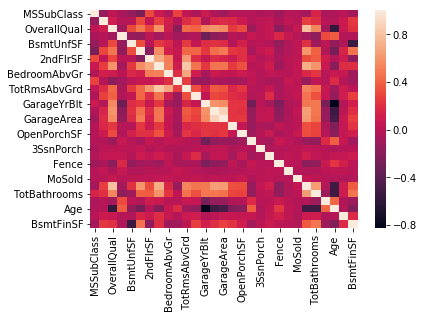

In [45]:
sns.heatmap(train1_cor)

In [46]:
c = train1.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [47]:
so.tail(50)

2ndFlrSF       TotRmsAbvGrd     0.616423
SalePrice      GarageArea       0.623431
GarageArea     SalePrice        0.623431
SalePrice      TotBathrooms     0.631731
TotBathrooms   SalePrice        0.631731
SalePrice      GarageCars       0.640409
GarageCars     SalePrice        0.640409
BedroomAbvGr   TotRmsAbvGrd     0.676620
TotRmsAbvGrd   BedroomAbvGr     0.676620
GrLivArea      2ndFlrSF         0.687501
2ndFlrSF       GrLivArea        0.687501
GrLivArea      SalePrice        0.708624
SalePrice      GrLivArea        0.708624
               OverallQual      0.790982
OverallQual    SalePrice        0.790982
Age            GarageYrBlt      0.824615
GarageYrBlt    Age              0.824615
TotRmsAbvGrd   GrLivArea        0.825489
GrLivArea      TotRmsAbvGrd     0.825489
GarageCars     GarageArea       0.882475
GarageArea     GarageCars       0.882475
MSSubClass     MSSubClass       1.000000
GarageArea     GarageArea       1.000000
Age            Age              1.000000
LotArea        L

###### From the heatmap, we noticed there is collinearity existing between GarageCars and GarageArea, GarageYrBlt and Age. We chose to keep GarageArea as it is a continuous variable and keep Age as it carries more information of the house.

In [48]:
#Drop highly correlated variables
train=train.drop(['GarageYrBlt',"GarageCars"],axis = 1)

In [49]:
test=test.drop(['GarageYrBlt',"GarageCars"],axis = 1)

In [52]:
train['GarageType']= train['GarageType'].fillna("No")
train['GarageFinish']= train['GarageFinish'].fillna("No")
train['GarageQual'] = train['GarageQual'].fillna("No")
train['GarageCond'] = train['GarageCond'].fillna("No")

In [53]:
test['GarageType']= test['GarageType'].fillna("No")
test['GarageFinish']= test['GarageFinish'].fillna("No")
test['GarageQual'] = test['GarageQual'].fillna("No")
test['GarageCond'] = test['GarageCond'].fillna("No")

###### We combined 3 types of porch as one variable

In [54]:
train["OtherPorch"] = train['EnclosedPorch']+train["3SsnPorch"]+train["ScreenPorch"]

In [55]:
test["OtherPorch"] = test['EnclosedPorch']+test["3SsnPorch"]+test["ScreenPorch"]

In [56]:
train = train.drop(['EnclosedPorch','3SsnPorch','ScreenPorch'],axis = 1) 

In [57]:
test = test.drop(['EnclosedPorch','3SsnPorch','ScreenPorch'],axis = 1) 

In [58]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Utilities', 'Neighborhood',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtUnfSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'Fence', 'MiscVal', 'MoSold', 'SaleType',
       'SaleCondition', 'SalePrice', 'TotBathrooms', 'Remodel', 'Age',
       'IsPool', 'BsmtFinSF', 'OtherPorch'],
      dtype='object')

In [60]:
train.shape

(1460, 52)

In [61]:
test.shape

(1459, 52)

###### We checked the distribution of 'SalePrice' and found out it is highly skewed and has a long right tail. Thus, we decided to do a log transform later.

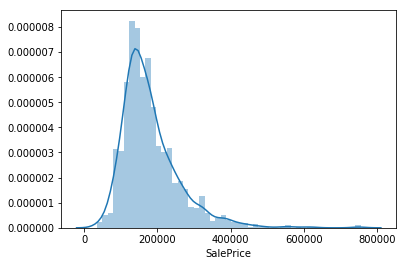

In [63]:
sns.distplot(train['SalePrice'])

###### We explored some variables in our data, and found there exist siginificant differences in SalePrice at different levels of independent variables.

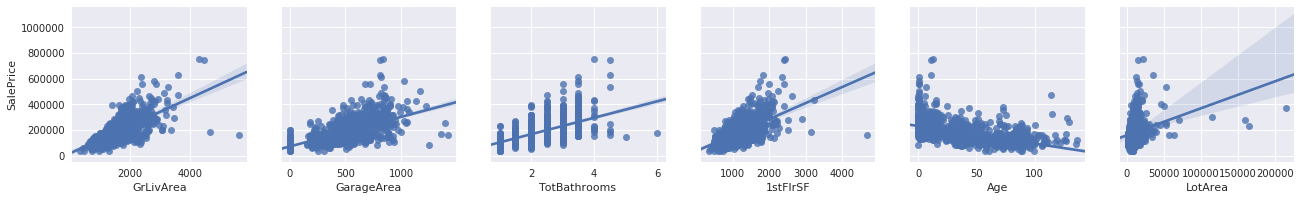

In [64]:
sns.set()
plotcols = ['GrLivArea', 'GarageArea', 'TotBathrooms', '1stFlrSF', 'Age','LotArea']
sns.pairplot(train, x_vars = plotcols, y_vars = 'SalePrice', size = 3, kind="reg")
plt.show()

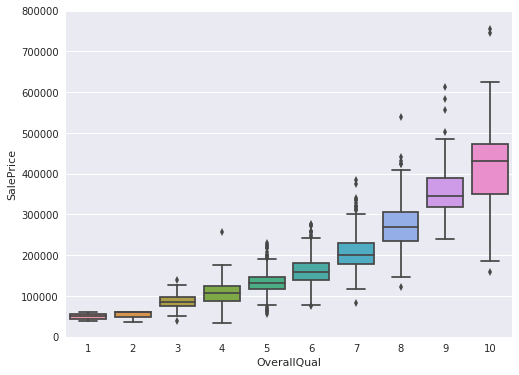

In [65]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

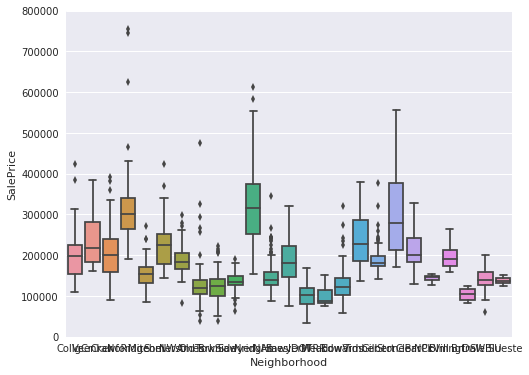

In [66]:
data = pd.concat([train['SalePrice'], train['Neighborhood']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Neighborhood', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

(-0.5, 3.5, 0, 800000)

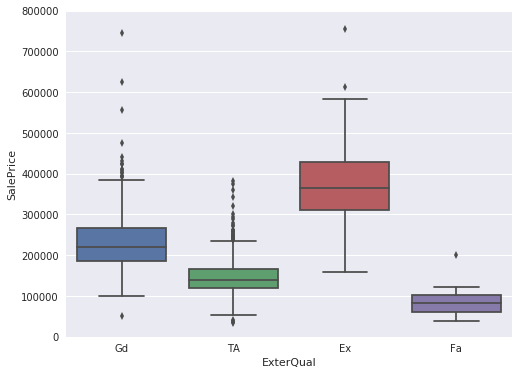

In [67]:
data = pd.concat([train['SalePrice'], train['ExterQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='ExterQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 3.5, 0, 800000)

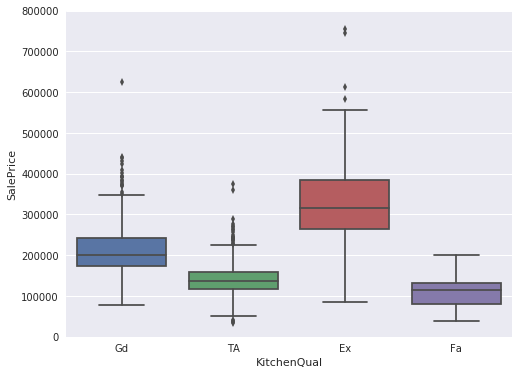

In [68]:
data = pd.concat([train['SalePrice'], train['KitchenQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='KitchenQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 4.5, 0, 800000)

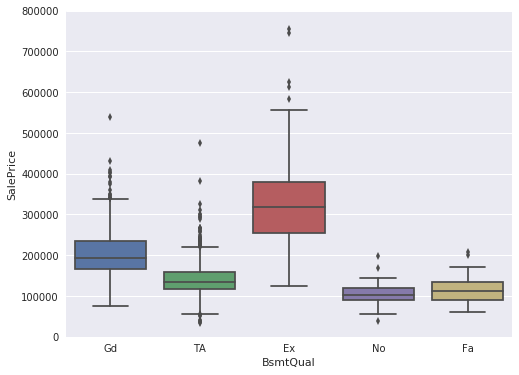

In [69]:
data = pd.concat([train['SalePrice'], train['BsmtQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='BsmtQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

###### So far, we finished our process of variables selection. We would split our dataset into train and validation, handle missing values and make imputation after the split.

### Split

In [70]:
train, valid = train_test_split(train, test_size=0.3, random_state=123)

In [71]:
valid.shape

(438, 52)

In [72]:
train.shape

(1022, 52)

###### We filled NA values in 'Electrical','MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd' 'KitchenQual','Functional' and  SaleType' column with mode value. We used mean value of 'GarageArea' to fill NA values.

In [73]:
train.Electrical.mode().item()

'SBrkr'

In [74]:
train[c]= train['Electrical'].fillna(train.Electrical.mode().item())

In [78]:
test.SaleType.mode().item()

'WD'

In [79]:
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)

In [80]:
test['BsmtFinSF'] = test['BsmtFinSF'].fillna(0)

In [81]:
test['MSZoning']= test['MSZoning'].fillna(test.MSZoning.mode().item())

In [82]:
test['Utilities']= test['Utilities'].fillna(test.Utilities.mode().item())

In [83]:
test['Exterior1st']= test['Exterior1st'].fillna(test.Exterior1st.mode().item())

In [84]:
test['Exterior2nd']= test['Exterior2nd'].fillna(test.Exterior2nd.mode().item())

In [85]:
test['KitchenQual']= test['KitchenQual'].fillna(test.KitchenQual.mode().item())

In [86]:
test['Functional']= test['Functional'].fillna(test.Functional.mode().item())

In [87]:
test['SaleType']= test['SaleType'].fillna(test.SaleType.mode().item())

In [88]:
test['GarageArea']= test['GarageArea'].fillna(test.GarageArea.mean())

In [89]:
test[test.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotArea,Utilities,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,...,MiscVal,MoSold,SaleType,SaleCondition,TotBathrooms,Remodel,Age,IsPool,BsmtFinSF,OtherPorch


###### After we handle missing values in our data, we did Target Encoding to encode our catagorical variables into numeri variable for model build.

### Target Encoding

In [90]:
numerics = ['int64','float64']
train1 = train.select_dtypes(include=numerics)
nums = train1.columns.tolist()

In [91]:
catgory = ['object']
train2 = train.select_dtypes(include=catgory)
cats = train2.columns.tolist()

In [92]:
trainpd = train
testpd = test
validpd = valid

In [93]:
trainpd.head()

,MSSubClass,MSZoning,LotArea,Utilities,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,...,MoSold,SaleType,SaleCondition,SalePrice,TotBathrooms,Remodel,Age,IsPool,BsmtFinSF,OtherPorch
376,85,RL,8846,AllPub,CollgCr,1Fam,SFoyer,5,5,Gable,...,7,WD,Normal,148000,1.0,0,10,0,298,0
250,30,RL,5350,AllPub,BrkSide,1Fam,1Story,3,2,Gable,...,5,WD,Normal,76500,1.0,1,70,0,0,0
228,20,RL,8521,AllPub,Sawyer,1Fam,1Story,5,5,Gable,...,5,WD,Normal,125000,1.0,0,43,0,842,0
40,20,RL,8658,AllPub,NAmes,1Fam,1Story,6,5,Gable,...,12,WD,Abnorml,160000,2.0,0,41,0,643,0
428,20,RL,6762,AllPub,CollgCr,1Fam,1Story,7,5,Gable,...,9,New,Partial,195400,3.0,0,0,0,664,0


In [94]:
train = h2o.H2OFrame(train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [95]:
valid = h2o.H2OFrame(valid)
test = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [96]:
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

Parse progress: |█████████████████████████████████████████████████████████| 100%
(1022, 52)
(1459, 53)


In [97]:
test.describe()

Rows:1459
Cols:53




,Id,MSSubClass,MSZoning,LotArea,Utilities,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,Fence,MiscVal,MoSold,SaleType,SaleCondition,TotBathrooms,Remodel,Age,IsPool,BsmtFinSF,OtherPorch,SalePrice
type,int,int,enum,int,enum,enum,enum,enum,int,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,int,int,int,int,int,enum,int,enum,int,enum,enum,real,enum,enum,enum,int,int,int,int,int,enum,enum,real,int,int,int,int,int,real
mins,1461.0,20.0,,1470.0,,,,,1.0,1.0,,,,,,,,,,0.0,,,,,407.0,0.0,407.0,0.0,0.0,,3.0,,0.0,,,0.0,,,,0.0,0.0,0.0,0.0,1.0,,,1.0,0.0,-1.0,0.0,0.0,0.0,0.00023775806909309696
mean,2190.0,57.37834132967793,,9819.161069225516,,,,,6.078821110349558,5.553803975325569,,,,,,,,,,553.9150102810141,,,,,1156.5346127484572,325.9677861549004,1486.0459218642889,2.8540095956134333,1.0424948594928027,,6.3851953392734755,,0.5812200137080195,,,472.7688614540469,,,,93.17477724468819,48.31391363947919,0.1987662782727896,58.16792323509254,6.104180945853339,,,2.226182316655241,0.4544208361891707,36.41192597669636,0.00411240575736806,491.4859492803294,43.102124742974624,0.5046722011717317
maxs,2919.0,190.0,,56600.0,,,,,10.0,9.0,,,,,,,,,,2140.0,,,,,5095.0,1862.0,5095.0,6.0,2.0,,15.0,,4.0,,,1488.0,,,,1424.0,742.0,1.0,17000.0,12.0,,,7.0,1.0,129.0,1.0,4010.0,1012.0,0.9991278660098124
sigma,421.32133421732476,42.746879618718204,,4955.517326926451,,,,,1.4368116404730202,1.1137396032892082,,,,,,,,,,437.3513241096486,,,,,398.16581959237874,420.61022646910345,485.5660986532532,0.8297883627354514,0.2084716721132495,,1.5088945751925396,,0.6474204530720105,,,216.97416468040285,,,,127.744881519076,68.88336411315396,0.39920856142499556,630.806977589708,2.722431901250807,,,0.8318339744062643,0.49808893053405867,30.432247629906666,0.064017988542015,478.4768976724821,87.33074864791641,0.2863709270335333
zeros,0,0,,0,,,,,0,0,,,,,,,,,,124,,,,,0,839,0,2,2,,0,,730,,,76,,,,762,642,1169,1408,0,,,0,796,52,1453,463,1076,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1461.0,20.0,RH,11622.0,AllPub,NAmes,1Fam,1Story,5.0,6.0,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,TA,TA,270.0,GasA,TA,Y,SBrkr,896.0,0.0,896.0,2.0,1.0,TA,5.0,Typ,0.0,Attchd,Unf,730.0,TA,TA,Y,140.0,0.0,1.0,0.0,6.0,WD,Normal,1.0,0.0,49.0,0.0,612.0,120.0,0.5256885346859623
1,1462.0,20.0,RL,14267.0,AllPub,NAmes,1Fam,1Story,6.0,6.0,Hip,CompShg,Wd Sdng,Wd Sdng,TA,TA,CBlock,TA,TA,406.0,GasA,TA,Y,SBrkr,1329.0,0.0,1329.0,3.0,1.0,Gd,6.0,Typ,0.0,Attchd,Unf,312.0,TA,TA,Y,393.0,36.0,0.0,12500.0,6.0,WD,Normal,1.5,0.0,52.0,0.0,923.0,0.0,0.4767764688852074
2,1463.0,60.0,RL,13830.0,AllPub,Gilbert,1Fam,2Story,5.0,5.0,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,Gd,TA,137.0,GasA,Gd,Y,SBrkr,928.0,701.0,1629.0,3.0,1.0,TA,6.0,Typ,1.0,Attchd,Fin,482.0,TA,TA,Y,212.0,34.0,1.0,0.0,3.0,WD,Normal,2.5,1.0,13.0,0.0,791.0,0.0,0.4522821162146115


In [98]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """
    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series

    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)


    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)

In [99]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Encoding: MSZoning (1/27) ...
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Encoding: Utilities (2/27) ...
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |███████████████████████████████

###### We Checked Neighborhood_Tencode.

In [100]:
print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _


Neighborhood,Neighborhood_Tencode
NAmes,154130
NAmes,154130
Gilbert,195843
Gilbert,195843
StoneBr,307827



{'BrkSide': 134038.50692541857, 'Blmngtn': 188599.25136986299, 'Gilbert': 195843.24447331126, 'NAmes': 154129.94239550401, 'Crawfor': 208390.99136986298, 'BrDale': 115645.45136986302, 'ClearCr': 225770.67864259027, 'NridgHt': 272182.00826641475, 'NWAmes': 183848.50692541854, 'IDOTRR': 121170.45136986302, 'NoRidge': 282642.52279843442, 'CollgCr': 199088.25136986299, 'Timber': 258113.951369863, 'OldTown': 141075.53201502431, 'Blueste': 155807.951369863, 'NPkVill': 146457.951369863, 'MeadowV': 95457.951369863018, 'StoneBr': 307826.56565557729, 'SWISU': 135832.951369863, 'Sawyer': 146289.72220319635, 'Somerst': 220901.49975695979, 'Veenker': 256957.951369863, 'Mitchel': 164475.92756033919, 'SawyerW': 179378.02636986299, 'Edwards': 129335.30851272016}
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [101]:
cats = train2.columns.tolist()

In [102]:
Y = 'SalePrice'
cats.append('SalePrice')
X = [name for name in train.columns if name not in cats]

In [103]:
len(X)

51

###### We checked log transform of our target variable SalePrice. The distribution looks good.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f073a7f3748>]], dtype=object)

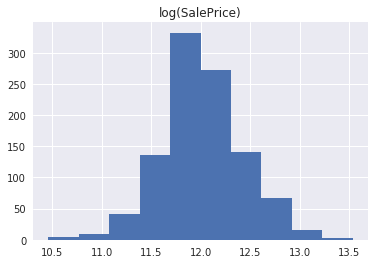

In [104]:
train['SalePrice'].log().as_data_frame().hist()

###### We executed log transform.

In [105]:
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

SalePrice
11.905
11.245
11.7361


##### 2. Build Model

In [107]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch 

In [108]:
def ranked_preds_plot(y, valid, preds):
    
    """ Generates ranked prediction plot.
    
    :param y: Name of target variable.
    :param valid: Name of validation H2OFrame.
    :param preds: Column vector of predictions to plot.

    """
    
    # plot top frame values
    preds.columns = ['predict']
    yhat_frame = valid.cbind(preds)
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')

In [109]:
import re
import time

def gen_submission(preds, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

######  2.1 GLM model

In [110]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])
    
    # select best model
    return best

In [111]:
glm_0 = glm_grid(X, 'SalePrice', train, valid)

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_166_sid_a79a_model_python_1524012755916_1_model_1   
1     [0.5]  Grid_GLM_py_166_sid_a79a_model_python_1524012755916_1_model_2   
2    [0.99]  Grid_GLM_py_166_sid_a79a_model_python_1524012755916_1_model_3   
3    [0.01]  Grid_GLM_py_166_sid_a79a_model_python_1524012755916_1_model_0   

    residual_deviance  
0   6.173178062244784  
1   6.177732367426408  
2  6.1804378396913515  
3   6.261807110608527  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_166_sid_a79a_model_python_1524012755916_1_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.018872974530538263
RMSE: 0.13737894500445935
MAE: 0.09302583310827264
RMSLE: 0.01057999443596372
R^2: 0.8859469133219231
Mean Residual Deviance: 0.018872974530538263
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2018-04-18 00:53:03,0.000 sec,1,.13E1,1,0.1654753,0.1456323
,2018-04-18 00:53:03,0.001 sec,2,.12E1,2,0.1553322,0.1372414
,2018-04-18 00:53:03,0.003 sec,3,.11E1,3,0.1450210,0.1286838
,2018-04-18 00:53:03,0.005 sec,4,.1E1,3,0.1330502,0.1186635
,2018-04-18 00:53:03,0.006 sec,5,.92E0,5,0.1202392,0.1076519
---,---,---,---,---,---,---,---
,2018-04-18 00:53:03,0.073 sec,51,.13E-1,39,0.0188393,0.0140993
,2018-04-18 00:53:03,0.075 sec,52,.12E-1,39,0.0188054,0.0141103
,2018-04-18 00:53:03,0.076 sec,53,.11E-1,40,0.0187740,0.0141481
,2018-04-18 00:53:03,0.078 sec,54,.97E-2,40,0.0187474,0.0141888



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.3127,12.2808
11.3737,11.4982
11.7753,11.914
12.522,12.4181
11.8494,11.9141
12.4646,12.325
12.6411,12.6849
11.7559,11.6724
11.9512,11.945
11.8982,11.7528


In [112]:
def glm_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = 'glm' + '.csv'
    h2o.download_csv(sub, sub_fname)

In [113]:
glm_submission(glm_0)

glm prediction progress: |████████████████████████████████████████████████| 100%


###### 2.2 Random Forest Model

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1524012755916_2


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.03910583322372157
RMSE: 0.19775194872294324
MAE: 0.13933421841454452
RMSLE: 0.015269501335088202
Mean Residual Deviance: 0.03910583322372157

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.03230065211853468
RMSE: 0.17972382178925164
MAE: 0.12802984753489458
RMSLE: 0.01385307486945141
Mean Residual Deviance: 0.03230065211853468

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.037020911065119705
RMSE: 0.19240818866441134
MAE: 0.1352549891888594
RMSLE: 0.014832641465219879
Mean Residual Deviance: 0.037020911065119705
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.1348173,0.0060635,0.127859,0.1468978,0.129695
mean_residual_deviance,0.0368519,0.0023493,0.0343071,0.0415449,0.0347038
mse,0.0368519,0.0023493,0.0343071,0.0415449,0.0347038
r2,0.7755374,0.0033774,0.7687870,0.7791228,0.7787024
residual_deviance,0.0368519,0.0023493,0.0343071,0.0415449,0.0347038
rmse,0.1917790,0.0060313,0.1852217,0.2038258,0.1862896
rmsle,0.0147794,0.0004976,0.0141282,0.0157569,0.0144532


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-04-18 00:53:07,4.177 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-04-18 00:53:07,4.186 sec,1.0,0.2488067,0.1835503,0.0619048,0.2170320,0.1643958,0.0471029
,2018-04-18 00:53:07,4.196 sec,2.0,0.2633764,0.1954879,0.0693671,0.2099089,0.1535849,0.0440618
,2018-04-18 00:53:07,4.203 sec,3.0,0.2501919,0.1883822,0.0625960,0.1939072,0.1429465,0.0376000
,2018-04-18 00:53:08,4.212 sec,4.0,0.2497796,0.1857210,0.0623898,0.1951382,0.1454566,0.0380789
---,---,---,---,---,---,---,---,---,---
,2018-04-18 00:53:10,6.404 sec,120.0,0.1976626,0.1387858,0.0390705,0.1795848,0.1276951,0.0322507
,2018-04-18 00:53:10,6.433 sec,121.0,0.1979911,0.1391786,0.0392005,0.1798990,0.1280361,0.0323637
,2018-04-18 00:53:10,6.462 sec,122.0,0.1982811,0.1394788,0.0393154,0.1800690,0.1281772,0.0324249
,2018-04-18 00:53:10,6.491 sec,123.0,0.1979427,0.1393814,0.0391813,0.1799662,0.1281093,0.0323878



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Neighborhood_Tencode,1395.0338135,1.0,0.0997482
OverallQual,1066.3375244,0.7643811,0.0762456
ExterQual_Tencode,953.8131104,0.6837204,0.0681999
Age,791.2328491,0.5671783,0.0565750
1stFlrSF,761.5807495,0.5459228,0.0544548
---,---,---,---
MiscVal,22.6974125,0.0162702,0.0016229
RoofMatl_Tencode,17.4675045,0.0125212,0.0012490
Heating_Tencode,12.3188095,0.0088305,0.0008808
IsPool,12.2393122,0.0087735,0.0008751



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.3127,12.2687
11.3737,11.7935
11.7753,11.9591
12.522,12.236
11.8494,11.8745
12.4646,12.3217
12.6411,12.4981
11.7559,11.7213
11.9512,11.9404
11.8982,11.7612



drf prediction progress: |████████████████████████████████████████████████| 100%


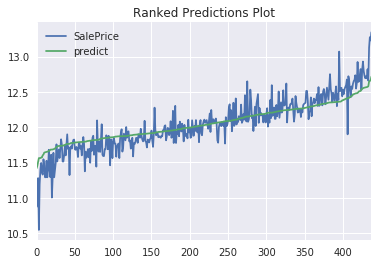

In [114]:
# initialize rf model
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345)           

# train rf model
rf_model1.train(
    x=X,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information
print(rf_model1)

rf_preds1_val = rf_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, rf_preds1_val) 
rf_preds1_test = rf_model1.predict(test)
gen_submission(rf_preds1_test) 

In [115]:
rf_model1._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,Neighborhood_Tencode,1395.033813,1.000000,0.099748
1,OverallQual,1066.337524,0.764381,0.076246
2,ExterQual_Tencode,953.813110,0.683720,0.068200
3,Age,791.232849,0.567178,0.056575
4,1stFlrSF,761.580750,0.545923,0.054455
5,GarageArea,756.292236,0.542132,0.054077
6,TotBathrooms,741.723022,0.531688,0.053035
7,GarageFinish_Tencode,703.276001,0.504128,0.050286
8,GrLivArea,650.170532,0.466061,0.046489
9,KitchenQual_Tencode,640.802979,0.459346,0.045819


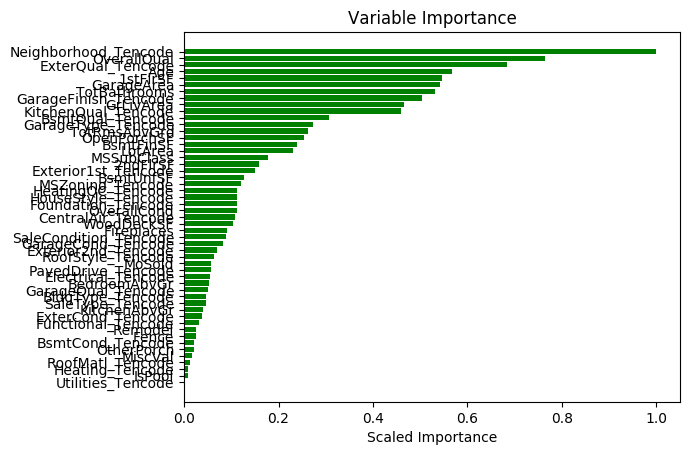

In [116]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = rf_model1._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = rf_model1._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

###### 2.3  Extra Trees Model

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1524012755916_3


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.039207593455843216
RMSE: 0.1980090741755115
MAE: 0.13966585623267472
RMSLE: 0.015289779232472232
Mean Residual Deviance: 0.039207593455843216

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.032230100333792686
RMSE: 0.17952743615891328
MAE: 0.12805617070763137
RMSLE: 0.013830788289798097
Mean Residual Deviance: 0.032230100333792686

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.03683008161432569
RMSE: 0.19191165054348755
MAE: 0.1347472675610591
RMSLE: 0.01479597493384876
Mean Residual Deviance: 0.03683008161432569
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.1343522,0.0054755,0.1281207,0.1452666,0.1296692
mean_residual_deviance,0.0366793,0.0021028,0.0344820,0.0408834,0.0346724
mse,0.0366793,0.0021028,0.0344820,0.0408834,0.0346724
r2,0.7763835,0.0045184,0.7676082,0.7826397,0.7789027
residual_deviance,0.0366793,0.0021028,0.0344820,0.0408834,0.0346724
rmse,0.1913650,0.0054178,0.1856933,0.2021966,0.1862053
rmsle,0.0147495,0.0004483,0.0141734,0.0156327,0.0144425


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-04-18 00:53:16,4.061 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-04-18 00:53:16,4.070 sec,1.0,0.2587990,0.1877450,0.0669769,0.2258483,0.1685215,0.0510074
,2018-04-18 00:53:16,4.078 sec,2.0,0.2728001,0.1954627,0.0744199,0.2046821,0.1520405,0.0418947
,2018-04-18 00:53:16,4.085 sec,3.0,0.2552415,0.1887094,0.0651482,0.1902528,0.1416143,0.0361961
,2018-04-18 00:53:16,4.096 sec,4.0,0.2533962,0.1851001,0.0642096,0.1885115,0.1403356,0.0355366
---,---,---,---,---,---,---,---,---,---
,2018-04-18 00:53:19,6.393 sec,122.0,0.1985199,0.1400017,0.0394102,0.1800406,0.1284053,0.0324146
,2018-04-18 00:53:19,6.423 sec,123.0,0.1981895,0.1399214,0.0392791,0.1799388,0.1283234,0.0323780
,2018-04-18 00:53:19,6.455 sec,124.0,0.1978424,0.1397296,0.0391416,0.1796813,0.1281531,0.0322854
,2018-04-18 00:53:19,6.486 sec,125.0,0.1983279,0.1400249,0.0393340,0.1801114,0.1284970,0.0324401



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Neighborhood_Tencode,1393.3315430,1.0,0.0972853
OverallQual,1135.6861572,0.8150868,0.0792960
ExterQual_Tencode,955.1090698,0.6854859,0.0666877
GarageArea,783.6406250,0.5624222,0.0547154
Age,780.3546143,0.5600638,0.0544860
---,---,---,---
MiscVal,22.5559978,0.0161885,0.0015749
RoofMatl_Tencode,18.1522751,0.0130280,0.0012674
IsPool,11.7199278,0.0084114,0.0008183
Heating_Tencode,11.4473152,0.0082158,0.0007993



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.3127,12.2626
11.3737,11.7673
11.7753,11.9461
12.522,12.2372
11.8494,11.8673
12.4646,12.3171
12.6411,12.4914
11.7559,11.7189
11.9512,11.9462
11.8982,11.7612



drf prediction progress: |████████████████████████████████████████████████| 100%


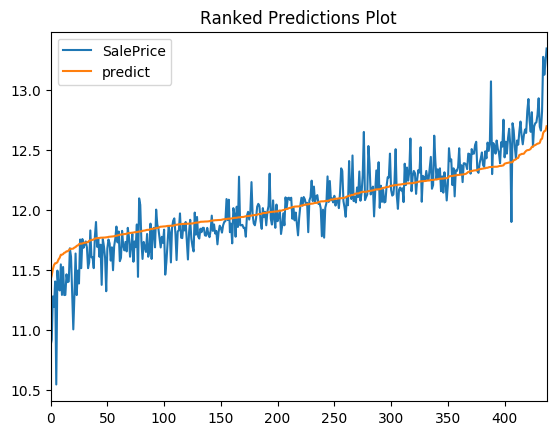

In [117]:
# initialize extra trees model
h2o.show_progress()
ert_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345,
    histogram_type='random') # <- this is what makes it ERT instead of RF

# train ert model
ert_model1.train(
    x=X,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information/create submission
print(ert_model1)
ert_preds1_val = ert_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, ert_preds1_val) 
ert_preds1_test = ert_model1.predict(test)
gen_submission(ert_preds1_test) 

In [118]:
ert_model1._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,Neighborhood_Tencode,1393.331543,1.000000,0.097285
1,OverallQual,1135.686157,0.815087,0.079296
2,ExterQual_Tencode,955.109070,0.685486,0.066688
3,GarageArea,783.640625,0.562422,0.054715
4,Age,780.354614,0.560064,0.054486
5,1stFlrSF,758.900757,0.544666,0.052988
6,TotBathrooms,741.024780,0.531837,0.051740
7,GrLivArea,727.173401,0.521895,0.050773
8,GarageFinish_Tencode,703.529602,0.504926,0.049122
9,KitchenQual_Tencode,645.138000,0.463018,0.045045


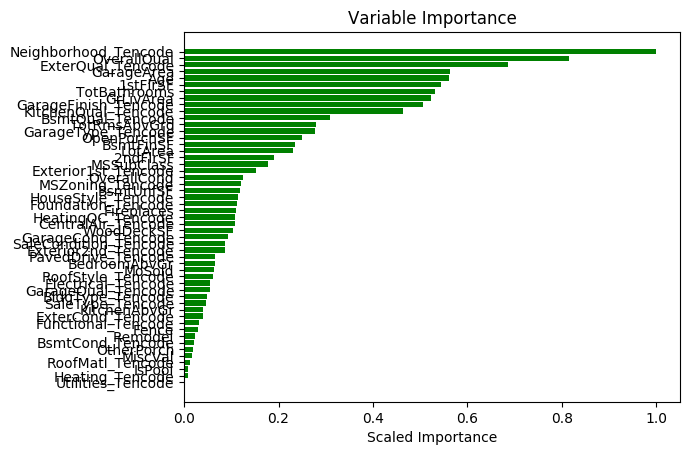

In [119]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = ert_model1._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ert_model1._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

### 2.4 Gradient Boosting Model

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1524012755916_4


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.004822770342887313
RMSE: 0.06944616866960562
MAE: 0.046652226532042144
RMSLE: 0.005384623766306062
Mean Residual Deviance: 0.004822770342887313

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.014441691398259234
RMSE: 0.1201735886052307
MAE: 0.0855330792206239
RMSLE: 0.0092759789905637
Mean Residual Deviance: 0.014441691398259234

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.020112688050612008
RMSE: 0.14181920903252848
MAE: 0.0963406993195823
RMSLE: 0.010946698471878739
Mean Residual Deviance: 0.020112688050612008
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0962768,0.0010977,0.0941471,0.0978037,0.0968796
mean_residual_deviance,0.0201933,0.0014322,0.0229997,0.0182934,0.0192867
mse,0.0201933,0.0014322,0.0229997,0.0182934,0.0192867
r2,0.8749161,0.0167035,0.8449932,0.9027418,0.8770134
residual_deviance,0.0201933,0.0014322,0.0229997,0.0182934,0.0192867
rmse,0.1419287,0.0049751,0.1516565,0.1352529,0.1388766
rmsle,0.0109569,0.0002980,0.0115222,0.0105110,0.0108375


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-04-18 00:54:10,49.219 sec,0.0,0.4067866,0.3144701,0.1654754,0.3816180,0.2978574,0.1456323
,2018-04-18 00:54:10,49.229 sec,1.0,0.4053665,0.3132431,0.1643220,0.3802839,0.2967593,0.1446159
,2018-04-18 00:54:10,49.234 sec,2.0,0.4037634,0.3118103,0.1630249,0.3788122,0.2954012,0.1434986
,2018-04-18 00:54:10,49.239 sec,3.0,0.4024434,0.3106552,0.1619607,0.3776517,0.2943823,0.1426208
,2018-04-18 00:54:10,49.246 sec,4.0,0.4010589,0.3094171,0.1608482,0.3762772,0.2931614,0.1415846
---,---,---,---,---,---,---,---,---,---
,2018-04-18 00:54:30,1 min 9.225 sec,5884.0,0.0823502,0.0557470,0.0067816,0.1163130,0.0812322,0.0135287
,2018-04-18 00:54:34,1 min 13.228 sec,7180.0,0.0775064,0.0522656,0.0060072,0.1177324,0.0826233,0.0138609
,2018-04-18 00:54:38,1 min 17.229 sec,8489.0,0.0734984,0.0494382,0.0054020,0.1189709,0.0842634,0.0141541
,2018-04-18 00:54:42,1 min 21.231 sec,9790.0,0.0699842,0.0469226,0.0048978,0.1202597,0.0854127,0.0144624



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
OverallQual,5229.1264648,1.0,0.4501082
Neighborhood_Tencode,1941.9633789,0.3713743,0.1671586
GrLivArea,1296.1903076,0.2478789,0.1115723
1stFlrSF,260.9991455,0.0499126,0.0224661
MSZoning_Tencode,250.5297699,0.0479104,0.0215649
---,---,---,---
Heating_Tencode,1.4388419,0.0002752,0.0001239
KitchenAbvGr,0.0800403,0.0000153,0.0000069
MiscVal,0.0,0.0,0.0
IsPool,0.0,0.0,0.0



See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.3127,12.3598
11.3737,11.5743
11.7753,11.9032
12.522,12.5365
11.8494,11.9354
12.4646,12.4436
12.6411,12.7833
11.7559,11.6337
11.9512,11.9196
11.8982,11.7575


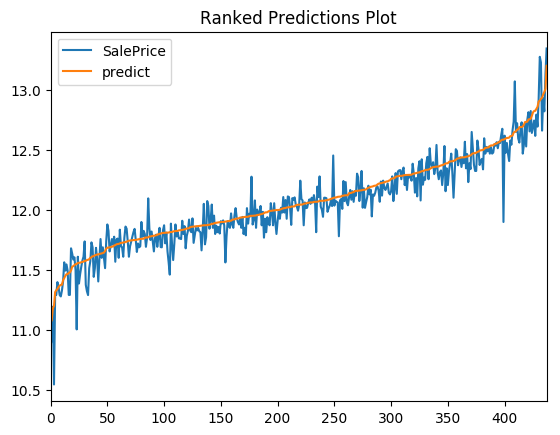

In [120]:
# initialize H2O GBM
h2o_gbm_model = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training
h2o_gbm_model.train(x=X,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_gbm_model)
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)
h2o_gbm_preds1_test = h2o_gbm_model.predict(test)
ranked_preds_plot('SalePrice', valid, h2o_gbm_preds1_val) 
gen_submission(h2o_gbm_preds1_test) 

In [121]:
h2o_gbm_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,OverallQual,5229.126465,1.000000,0.450108
1,Neighborhood_Tencode,1941.963379,0.371374,0.167159
2,GrLivArea,1296.190308,0.247879,0.111572
3,1stFlrSF,260.999146,0.049913,0.022466
4,MSZoning_Tencode,250.529770,0.047910,0.021565
5,GarageArea,226.985535,0.043408,0.019538
6,ExterQual_Tencode,209.153458,0.039998,0.018003
7,BsmtFinSF,190.558624,0.036442,0.016403
8,LotArea,188.420853,0.036033,0.016219
9,KitchenQual_Tencode,175.229034,0.033510,0.015083


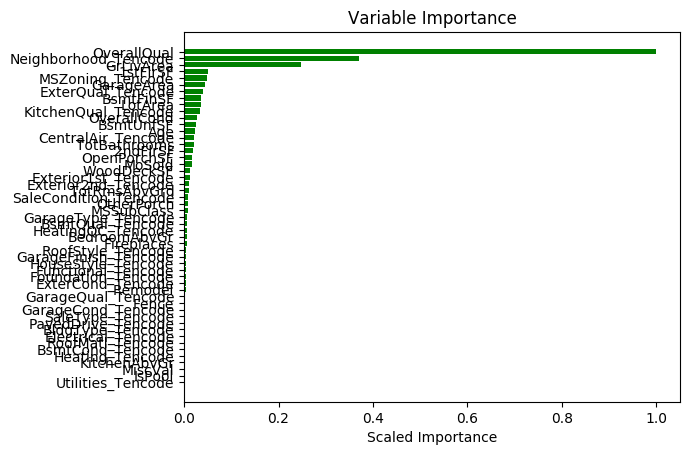

In [122]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = h2o_gbm_model._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = h2o_gbm_model._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

###### 2.5 XGB GBM

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1524012755916_7


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.03224687825620474
RMSE: 0.17957415809688412
MAE: 0.11520831039040523
RMSLE: 0.0139474178955278
Mean Residual Deviance: 0.03224687825620474

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.024602511112519276
RMSE: 0.15685187634363598
MAE: 0.1101110754492076
RMSLE: 0.012208767024958109
Mean Residual Deviance: 0.024602511112519276

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.055298992361865494
RMSE: 0.23515737785973354
MAE: 0.169846912652779
RMSLE: 0.018309865528948126
Mean Residual Deviance: 0.055298992361865494
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.1542760,0.0035153,0.1584561,0.1570817,0.1472903
mean_residual_deviance,0.0512375,0.0028548,0.0552529,0.0527449,0.0457146
mse,0.0512375,0.0028548,0.0552529,0.0527449,0.0457146
r2,0.6903619,0.0172518,0.6660961,0.681252,0.7237376
residual_deviance,0.0512375,0.0028548,0.0552529,0.0527449,0.0457146
rmse,0.2261772,0.0063770,0.2350593,0.2296627,0.2138098
rmsle,0.0176143,0.0005881,0.0183199,0.0180765,0.0164466


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-04-18 01:12:21,3 min 38.148 sec,0.0,11.5228721,11.5156895,132.7765809,11.5498333,11.5435607,133.3986490
,2018-04-18 01:12:22,3 min 38.180 sec,1.0,11.4651789,11.4580149,131.4503281,11.4920614,11.4858064,132.0674747
,2018-04-18 01:12:22,3 min 38.195 sec,2.0,11.4077744,11.4006286,130.1373161,11.4345784,11.4283409,130.7495838
,2018-04-18 01:12:22,3 min 38.211 sec,3.0,11.3506569,11.3435292,128.8374128,11.3773830,11.3711627,129.4448432
,2018-04-18 01:12:22,3 min 38.228 sec,4.0,11.2938252,11.2867154,127.5504871,11.3204736,11.3142704,128.1531220
---,---,---,---,---,---,---,---,---,---
,2018-04-18 01:13:42,4 min 58.430 sec,3191.0,0.1795742,0.1152083,0.0322469,0.1568519,0.1101111,0.0246025
,2018-04-18 01:13:46,5 min 2.440 sec,3314.0,0.1795742,0.1152083,0.0322469,0.1568519,0.1101111,0.0246025
,2018-04-18 01:13:50,5 min 6.445 sec,3437.0,0.1795742,0.1152083,0.0322469,0.1568519,0.1101111,0.0246025
,2018-04-18 01:13:54,5 min 10.467 sec,3563.0,0.1795742,0.1152083,0.0322469,0.1568519,0.1101111,0.0246025



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
LotArea,7229.0,1.0,0.1743987
MSSubClass,5841.0,0.8079956,0.1409134
1stFlrSF,3372.0,0.4664546,0.0813491
GrLivArea,2958.0,0.4091852,0.0713614
GarageArea,2166.0,0.2996265,0.0522545
---,---,---,---
BsmtCond_Tencode,36.0,0.0049799,0.0008685
GarageQual_Tencode,30.0,0.0041500,0.0007237
CentralAir_Tencode,30.0,0.0041500,0.0007237
KitchenAbvGr,27.0,0.0037350,0.0006514



See the whole table with table.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


SalePrice,predict
12.3127,12.2784
11.3737,11.7246
11.7753,12.0293
12.522,12.4546
11.8494,11.8477
12.4646,12.4064
12.6411,12.5563
11.7559,11.7534
11.9512,11.8719
11.8982,11.6783


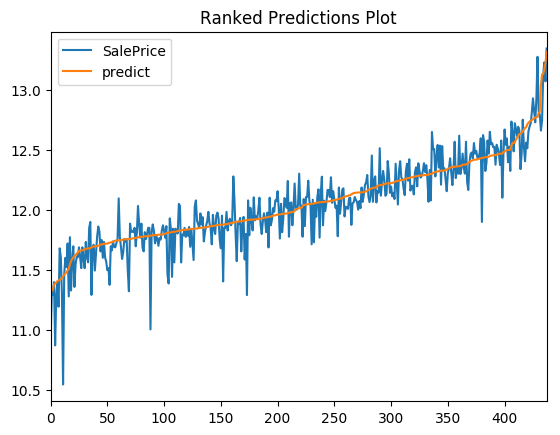

In [127]:
# initialize XGB GBM
h2o_xgb_model = H2OXGBoostEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training 
h2o_xgb_model.train(x=X,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_xgb_model)
h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
ranked_preds_plot('SalePrice', valid, h2o_xgb_preds1_val) 
gen_submission(h2o_xgb_preds1_test)

In [124]:
h2o_xgb_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,LotArea,7229.0,1.000000,0.174399
1,MSSubClass,5841.0,0.807996,0.140913
2,1stFlrSF,3372.0,0.466455,0.081349
3,GrLivArea,2958.0,0.409185,0.071361
4,GarageArea,2166.0,0.299627,0.052254
5,OverallQual,2011.0,0.278185,0.048515
6,BsmtFinSF,1622.0,0.224374,0.039131
7,BsmtUnfSF,1546.0,0.213861,0.037297
8,Neighborhood_Tencode,1258.0,0.174021,0.030349
9,Age,1199.0,0.165860,0.028926


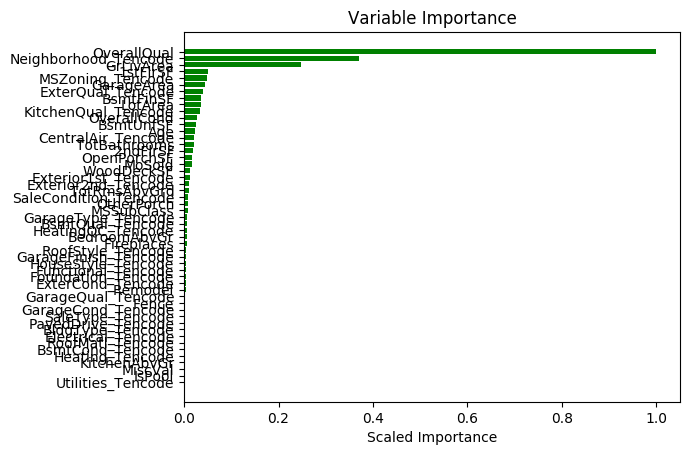

In [125]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = h2o_gbm_model._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = h2o_gbm_model._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

In [129]:
h2o.cluster().shutdown()

##### Conclusion
###### In these five model we built, we found the RMSLE of Gradient Boost model is the smallest for validation set. Thus, we choose Gradient Boost model as our final model for best result. From the Variable Importance table, we can learn variable sensitivity to understand which variables have stronger impact on the house price